# Create media designs using Latin Hypercube for the extended design space for the flaviolin production

This notebook generates a set of media designs using Latin Hypercube sampling as well as ART trained on previous cycles. We use ART's capability to provide this kind of designs for media components for which to get phenotypic data. We will use absorbance at 340nm as assay for this experiment.  


We include a design that is very close to the standard media (up to 10% variation for each component), as a control for every cycle.

Tested using **ART_3.9** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [ ]:
import os
import sys
# sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../../media_compiler')
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from art.core import RecommendationEngine 
import art.plot as plot
import edd_utils as eddu
from core import designs_pairwise


In [2]:
warnings.filterwarnings("ignore")

## User parameters

### Defining media components and the number of instances (designs) to be created

In [3]:
CYCLE = 7

user_params = {
    'bounds_file': f'../data/Putida_media_bounds_extended.csv',
    'output_file_path': f'../data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/standard_recipe_concentrations_extended.csv',
    'study_slug_1': 'combinatorial-media-for-flaviolin-dbtl1-ed1e',
    'study_slug_2': 'combinatorial-media-for-flaviolin-dbtl-2',
    'study_slug_3': 'combinatorial-media-for-flaviolin-dbtl-3',
    'study_slug_4': 'combinatorial-media-for-flaviolin-dbtl-4',
    'study_slug_5': 'combinatorial-media-for-flaviolin-dbtl-5',
    'study_slug_6': 'combinatorial-media-for-flaviolin-dbtl-6',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
}

Specify which components to explore:

In [4]:
user_params['components'] = [
    'H3BO3[mM]',
    'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    'CaCl2[mM]'    
]

user_params['response'] = 'OD340'

Here we specify how many instances (designs) we want to create and how many replicates (change as desired). In this case we run 12 instances with Latin Hypercube designs on the extended space, 3 instances recommended by ART using all previous data and 1 control design.

In [5]:
user_params['n_instances_lhs'] = 12
user_params['n_instances_art'] = 3
user_params['n_replicates'] = 3 

In [6]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [7]:
df_stand

,Concentration,Solubility
Component,,
MOPS[mM],40.00000,2389.37
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,763.38
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,688.47
K2HPO4[mM],1.32000,9185.90
FeSO4[mM],0.01000,1438.75
NH4Cl[mM],9.52000,5290.71
MgCl2[mM],0.52000,11558.70


## Generate the control media 

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [8]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration']
    df_control.at[0, component] = stand_conc*np.random.uniform(lb, ub)

df_control['Label'] = 'standard'

In [9]:
df_control

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],Label
0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0,standard


In [8]:
df_control.loc[0] = np.array(
    [0.003953,
     19.387198,
     0.278908,
     1.345779,
     0.009727,
     10.453468,
     0.473207,
     49.210832,
     0.000032,
     0.000276,
     0.000094,
     0.00082,
     0.000109,
     0.0]
)

## Generate random media using LHS

Define a dictionary that contains the settings that ART will use to find the recommended designs:

In [10]:
art_params = {
    'input_vars': user_params['components'],  # input variables, i.e. features
    'bounds_file': user_params['bounds_file'],  # file with bounds
    'num_recommendations': user_params['n_instances_lhs'],   
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': 10,                                               # seed for number random generator
    'output_directory': f"{user_params['output_file_path']}/lhs"  # directory to store this output
}


With the configuration stored in `art_params`, we now run ART:

In [11]:
art_init = RecommendationEngine(**art_params)
df_lhs = art_init.recommendations.copy()
df_lhs.tail()

Defaulting to a maximum of 72 cores for MCMC sampling (all available).  See the max_mcmc_cores parameter to control ART's use of parallelism.


,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM]
7,0.012424,181.876355,0.241431,1.656642,0.059312,19.734849,0.356876,663.059555,0.000011,0.001437,0.003679,0.003564,0.001221,0.027068
8,0.048945,20.311279,0.530003,9.252166,0.045107,12.286710,2.448971,1744.298800,0.000412,0.002198,0.002808,0.012728,0.000278,0.012130
9,0.021620,142.387906,0.062276,12.757317,0.055100,43.167051,1.695228,1203.273772,0.000380,0.004968,0.000730,0.001982,0.001415,0.006742
10,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207
11,0.070534,132.796955,0.674164,1.071211,0.005113,39.162269,2.005143,2173.248716,0.000305,0.000863,0.000352,0.005792,0.000432,0.031488


In [51]:
df_target = df_lhs.copy()
df_target['Label'] = 'LHS'

### Checking the distribution of initial designs

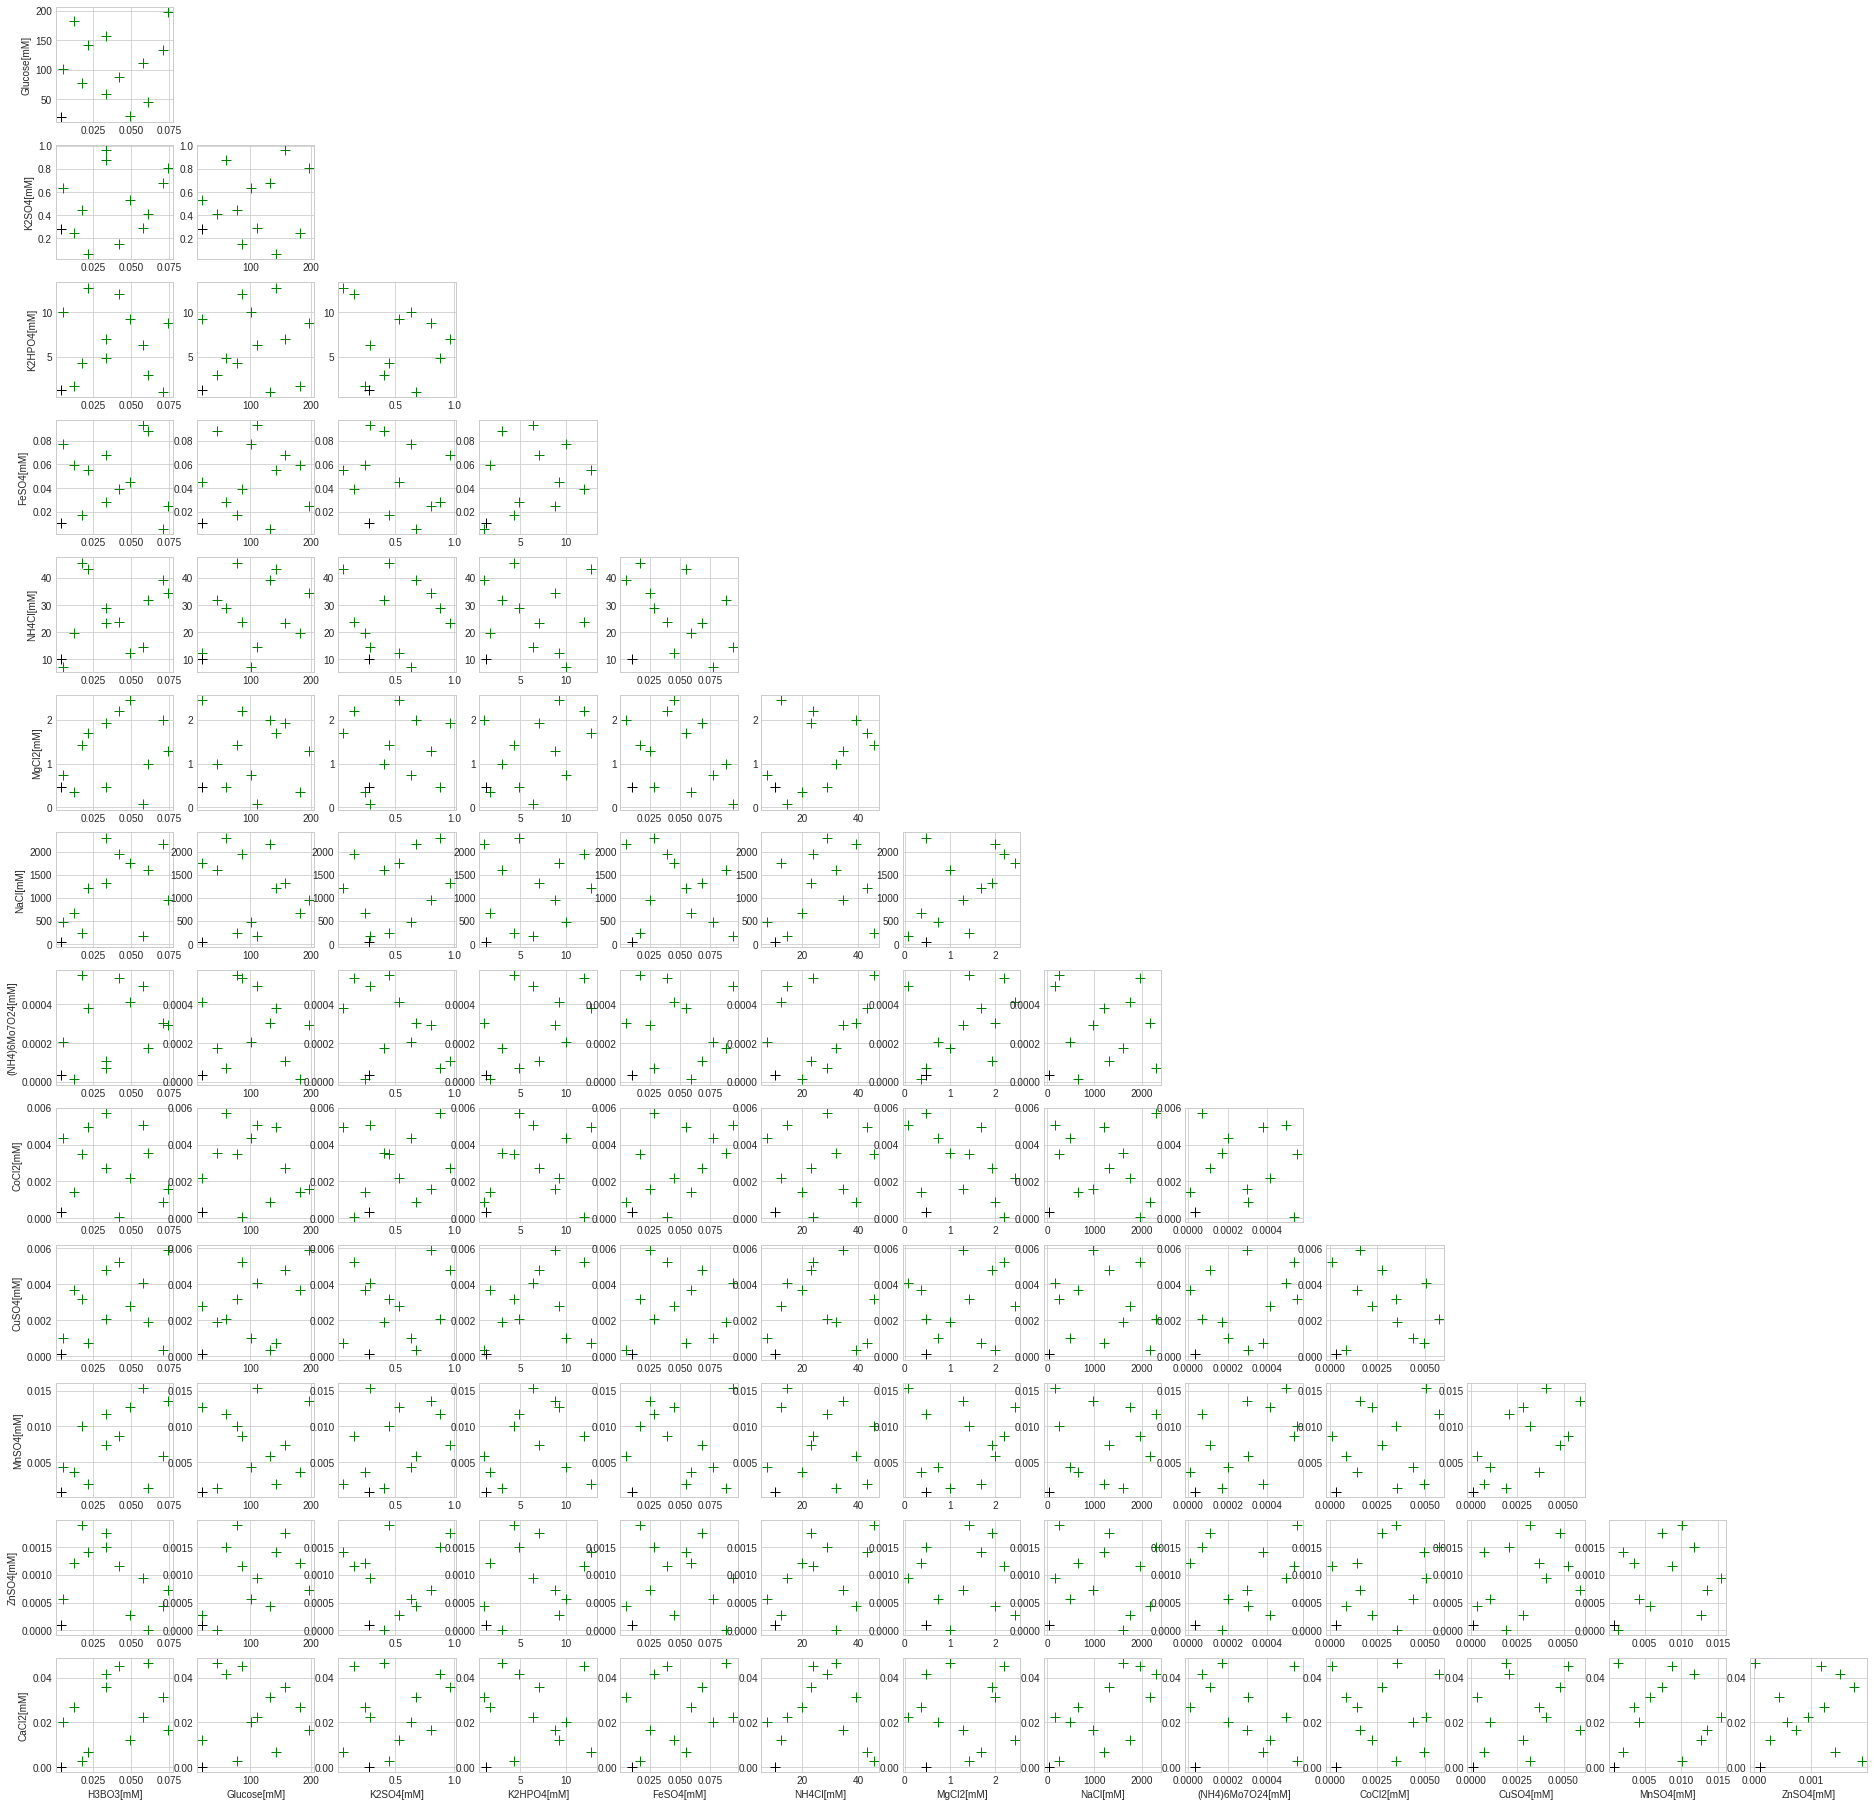

In [13]:
designs_pairwise(art_init, df_lhs, user_params, df_control=df_control)

## Generate ART suggested media

**Train ART on all previous data (DBTL 1-6)**

### Load the data

In [13]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']
study_slug_6 = user_params['study_slug_6']

edd_server = user_params['edd_server']
username = user_params['username']

In [14]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [15]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)
    df_6 = eddu.export_study(session, study_slug_6, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')


100%|█████████████████████████████████████████| 96/96 [00:00<00:00, 3543.89it/s]


Concatenate the six studies:

In [16]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])

Drop unnecessary columns:

In [17]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


Pivot the dataframe to include columns for all protocols:

In [18]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Protocol", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


#### Adding media information to the data frame

Add columns for each component:

In [19]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None


And assign values for each component and line:

In [20]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
283,C6_WD7_F7-R2,0.3230,0.621,40.0,4.0,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
284,C6_WD7_F7-R3,0.3304,0.424,40.0,4.0,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
285,C6_WD8_F8-R1,0.2993,1.064,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103
286,C6_WD8_F8-R2,0.3000,0.980,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103
287,C6_WD8_F8-R3,0.2958,1.275,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103


#### Include units into column names to match the new format from DBTL 7

In [21]:
comp = df.columns.drop(['Line Name', 'OD340', 'OD600'])
comp_units = [f'{col}[mM]' for col in comp]
col_rename = dict(zip(comp, comp_units))

df.rename(columns=col_rename, inplace=True)


#### Include CaCl2 value into all previous cycles

In [22]:
df["CaCl2[mM]"] = 0

In [23]:
df.head()

Protocol,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM]
0,C1_WA1_A4-R1,0.4422,2.019,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0
1,C1_WA1_A4-R2,0.3405,0.516,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0
2,C1_WA1_A4-R3,0.3397,0.436,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0
3,C1_WA1_A4-R4,0.3602,0.623,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0
4,C1_WA5_A8-R1,0.2699,0.699,40.0,4.0,0.009185,20.0,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0


Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [24]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

In [39]:
control_lines

Protocol,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2
44,C1_WF5_F8-R1,0.2856,0.731,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0
45,C1_WF5_F8-R2,0.2936,0.763,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0
46,C1_WF5_F8-R3,0.2715,0.664,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0
47,C1_WF5_F8-R4,0.2891,0.795,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0
92,C2_WF5_F8-R1,0.2934,0.631,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0
93,C2_WF5_F8-R2,0.2912,0.593,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0
94,C2_WF5_F8-R3,0.3004,0.601,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0
95,C2_WF5_F8-R4,0.2990,0.671,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0
141,C3_WD8_F8-R1,0.2813,1.022,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0
142,C3_WD8_F8-R2,0.2755,0.800,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0


How many designs improve response over the standard recipe?

In [26]:
control_response = np.max(control_lines['OD340'])
num_improved_response = np.sum(df['OD340'] > control_response)
num_designs = len(df) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of OD340 ({num_improved_response/num_designs*100:.2f}%).')


217 samples out of 268 improve over the standard in terms of OD340 (80.97%).


#### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [25]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS[mM],40.0
3,C1_WA1_A4-R1,Tricine[mM],4.0
4,C1_WA1_A4-R1,H3BO3[mM],0.003744


### ART training

Define a dictionary that contains the settings that ART will use to generate a predictive model:

In [26]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds# input variables, i.e. features
    'seed': 10,                                           # seed for number random generator
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],  # directory to store this output
    'scale_input_vars': True,
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 10
}

We will first run only model building part and then proceed with optimization using the two modes - exploration and exploitation>

In [27]:
user_params['alpha_exploit'] = None

user_params['n_instances_exploit'] = user_params['n_instances_art'] + 7  # 10 in total. We generate more than needed in case some of them do not have feasible volumes


With the configuration stored in art_params, we now run ART:

In [28]:
run_art = False

In [29]:
%%time
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art_4tpots.pkl'), 'rb') as output:
        art = pickle.load(output)

CPU times: user 359 ms, sys: 74.2 ms, total: 433 ms
Wall time: 1.86 s


In [19]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.110699,32.846487,0.086274,0.019698,0.034496
Random Forest Regressor,0.053110,14.009833,0.042303,0.004610,0.774021
Support Vector Regressor,0.076062,21.542186,0.049603,0.008246,0.595817
Kernel Ridge Regressor,0.099094,23.685700,0.079295,0.016107,0.210469
K-NN Regressor,0.066459,19.116251,0.057176,0.007686,0.623266
Gaussian Process Regressor,0.065316,19.234135,0.062690,0.008196,0.598250
Gradient Boosting Regressor,0.052266,13.719539,0.038509,0.004215,0.793408
TPOT Regressor,0.062500,15.088341,0.050830,0.006490,0.681886
TPOT Regressor,0.057147,15.442914,0.046984,0.005473,0.731721


In [ ]:
art.save_pkl_object()

### Exploitation recommendations

In [30]:
art.niter = 100000
art.alpha = user_params['alpha_exploit']
art.num_recommendations = user_params['n_instances_exploit'] # 7 in this DBTL4
art.rel_rec_distance = 2. # Default is 0.2
# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 
# Stops when 7 recommendations are found.
# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.


In [ ]:
art.save_pkl_object()

In [32]:
run_art_rec = False

In [33]:
%%time
if run_art_rec:
    draws = art.parallel_tempering_opt()
    art.recommend(draws)
else:
    art.recommendations = pd.read_csv(
        f"{art.outDir}/recommendations.csv",
        sep='\t',
        index_col=0 
    ) 
    

CPU times: user 6.73 ms, sys: 6.08 ms, total: 12.8 ms
Wall time: 9.74 ms


In [34]:
art.recommendations

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340
0,0.047111,197.422995,0.188252,6.008787,0.047223,17.288400,2.455039,1583.290896,0.000446,0.001542,0.003910,0.004854,0.001000,0.013365,0.649214
1,0.065692,191.631622,0.046334,4.770218,0.050439,28.631903,1.901839,2296.881765,0.000292,0.004766,0.002414,0.004017,0.000883,0.019156,0.648913
2,0.023089,191.921217,0.129778,10.082546,0.048329,25.802273,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696,0.643746
3,0.061695,186.267165,0.192915,12.522271,0.056789,31.510292,1.550108,2185.007779,0.000288,0.005237,0.004352,0.003203,0.000090,0.008350,0.643139
4,0.071373,147.224274,0.199419,4.768084,0.032527,27.749090,1.747975,1871.940755,0.000534,0.000078,0.001086,0.015091,0.001588,0.004578,0.640883
5,0.045773,188.539619,0.173068,11.799110,0.070873,15.991866,0.608421,2197.751131,0.000427,0.004253,0.005805,0.007190,0.000501,0.042193,0.640335
6,0.073086,193.129868,0.085112,4.575550,0.094685,14.931901,1.899201,704.700534,0.000139,0.001155,0.004476,0.012656,0.000398,0.041742,0.639287
7,0.017108,187.225185,0.052640,12.648487,0.068435,43.190404,2.577152,1485.255096,0.000293,0.004483,0.005004,0.014359,0.001562,0.049145,0.638896
8,0.079935,193.471389,0.142360,6.612490,0.048914,34.086158,1.081470,1556.853291,0.000508,0.005310,0.003314,0.010667,0.001806,0.023409,0.635813
9,0.057354,199.174302,0.524430,4.524089,0.015392,13.640098,2.568692,1721.374154,0.000544,0.005526,0.004591,0.013468,0.001154,0.023101,0.614585


In [35]:
art.save_pkl_object()

In [36]:
df_rec = art.recommendations.iloc[:3, :].copy()

In [37]:
df_rec.rename(columns={'OD340': 'OD340_pred'}, inplace=True)
df_rec['Label'] = 'exploitation'

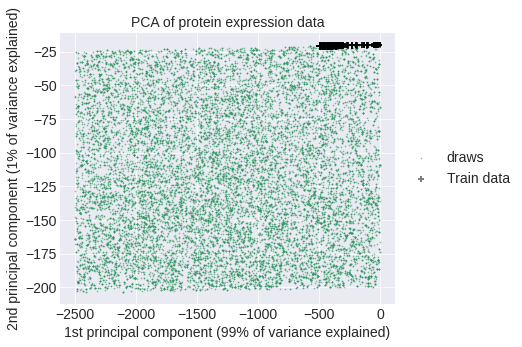

In [28]:
plot.draws_pc(art, draws, plot_scale_factor=100, plot_draws=True, plot_kde=False)


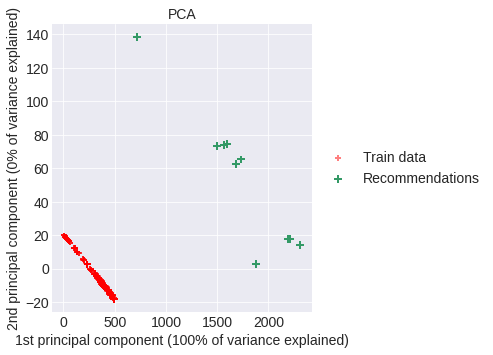

In [32]:
plot.recommendations_pc(art, plot_scale_factor=100)


In [31]:
plot.model_pairwise(art)

Append to the target designs:

In [52]:
df_target = df_target.append(df_rec).reset_index(drop=True)


In [53]:
df_target.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],Label,OD340_pred
0,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.932010,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,NaN
1,0.073964,197.001031,0.805718,8.730541,0.024996,34.480900,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.016770,LHS,NaN
2,0.005516,101.442383,0.635196,10.018421,0.077301,7.171802,0.739322,483.353887,0.000204,0.004384,0.001032,0.004261,0.000571,0.020192,LHS,NaN
3,0.061079,44.187891,0.408155,2.982336,0.088320,32.028222,0.998663,1609.826168,0.000172,0.003531,0.001917,0.001345,0.000011,0.046568,LHS,NaN
4,0.017981,77.852755,0.448481,4.311510,0.016822,45.664006,1.414916,242.476189,0.000552,0.003502,0.003175,0.010114,0.001898,0.002613,LHS,NaN


### Check the distribution of designs

Define dataframe with train data and predictions:

In [42]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']

In [43]:
df_train.head()

Protocol,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340
0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.4422
1,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3405
2,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3397
3,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3602
4,0.009185,20.0,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0,0.2699


Add predictions, cv-predictions and standard deviation of the OD340 predictions for the train data:

In [44]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [45]:
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [46]:
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [47]:
df_train.head()

Protocol,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.4422,0.378035,0.062557,0.374855,0.066082,train
1,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3405,0.378035,0.062557,0.374855,0.066082,train
2,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3397,0.378035,0.062557,0.374855,0.066082,train
3,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3602,0.378035,0.062557,0.374855,0.066082,train
4,0.009185,20.0,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0,0.2699,0.270589,0.062521,0.255072,0.065875,train


Save train data set for this cycle:

In [55]:
file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)

Append the control to the target designs:

In [54]:
df_target = df_target.append(df_control).reset_index(drop=True)

Red are train data, green are recommendations, black are standards

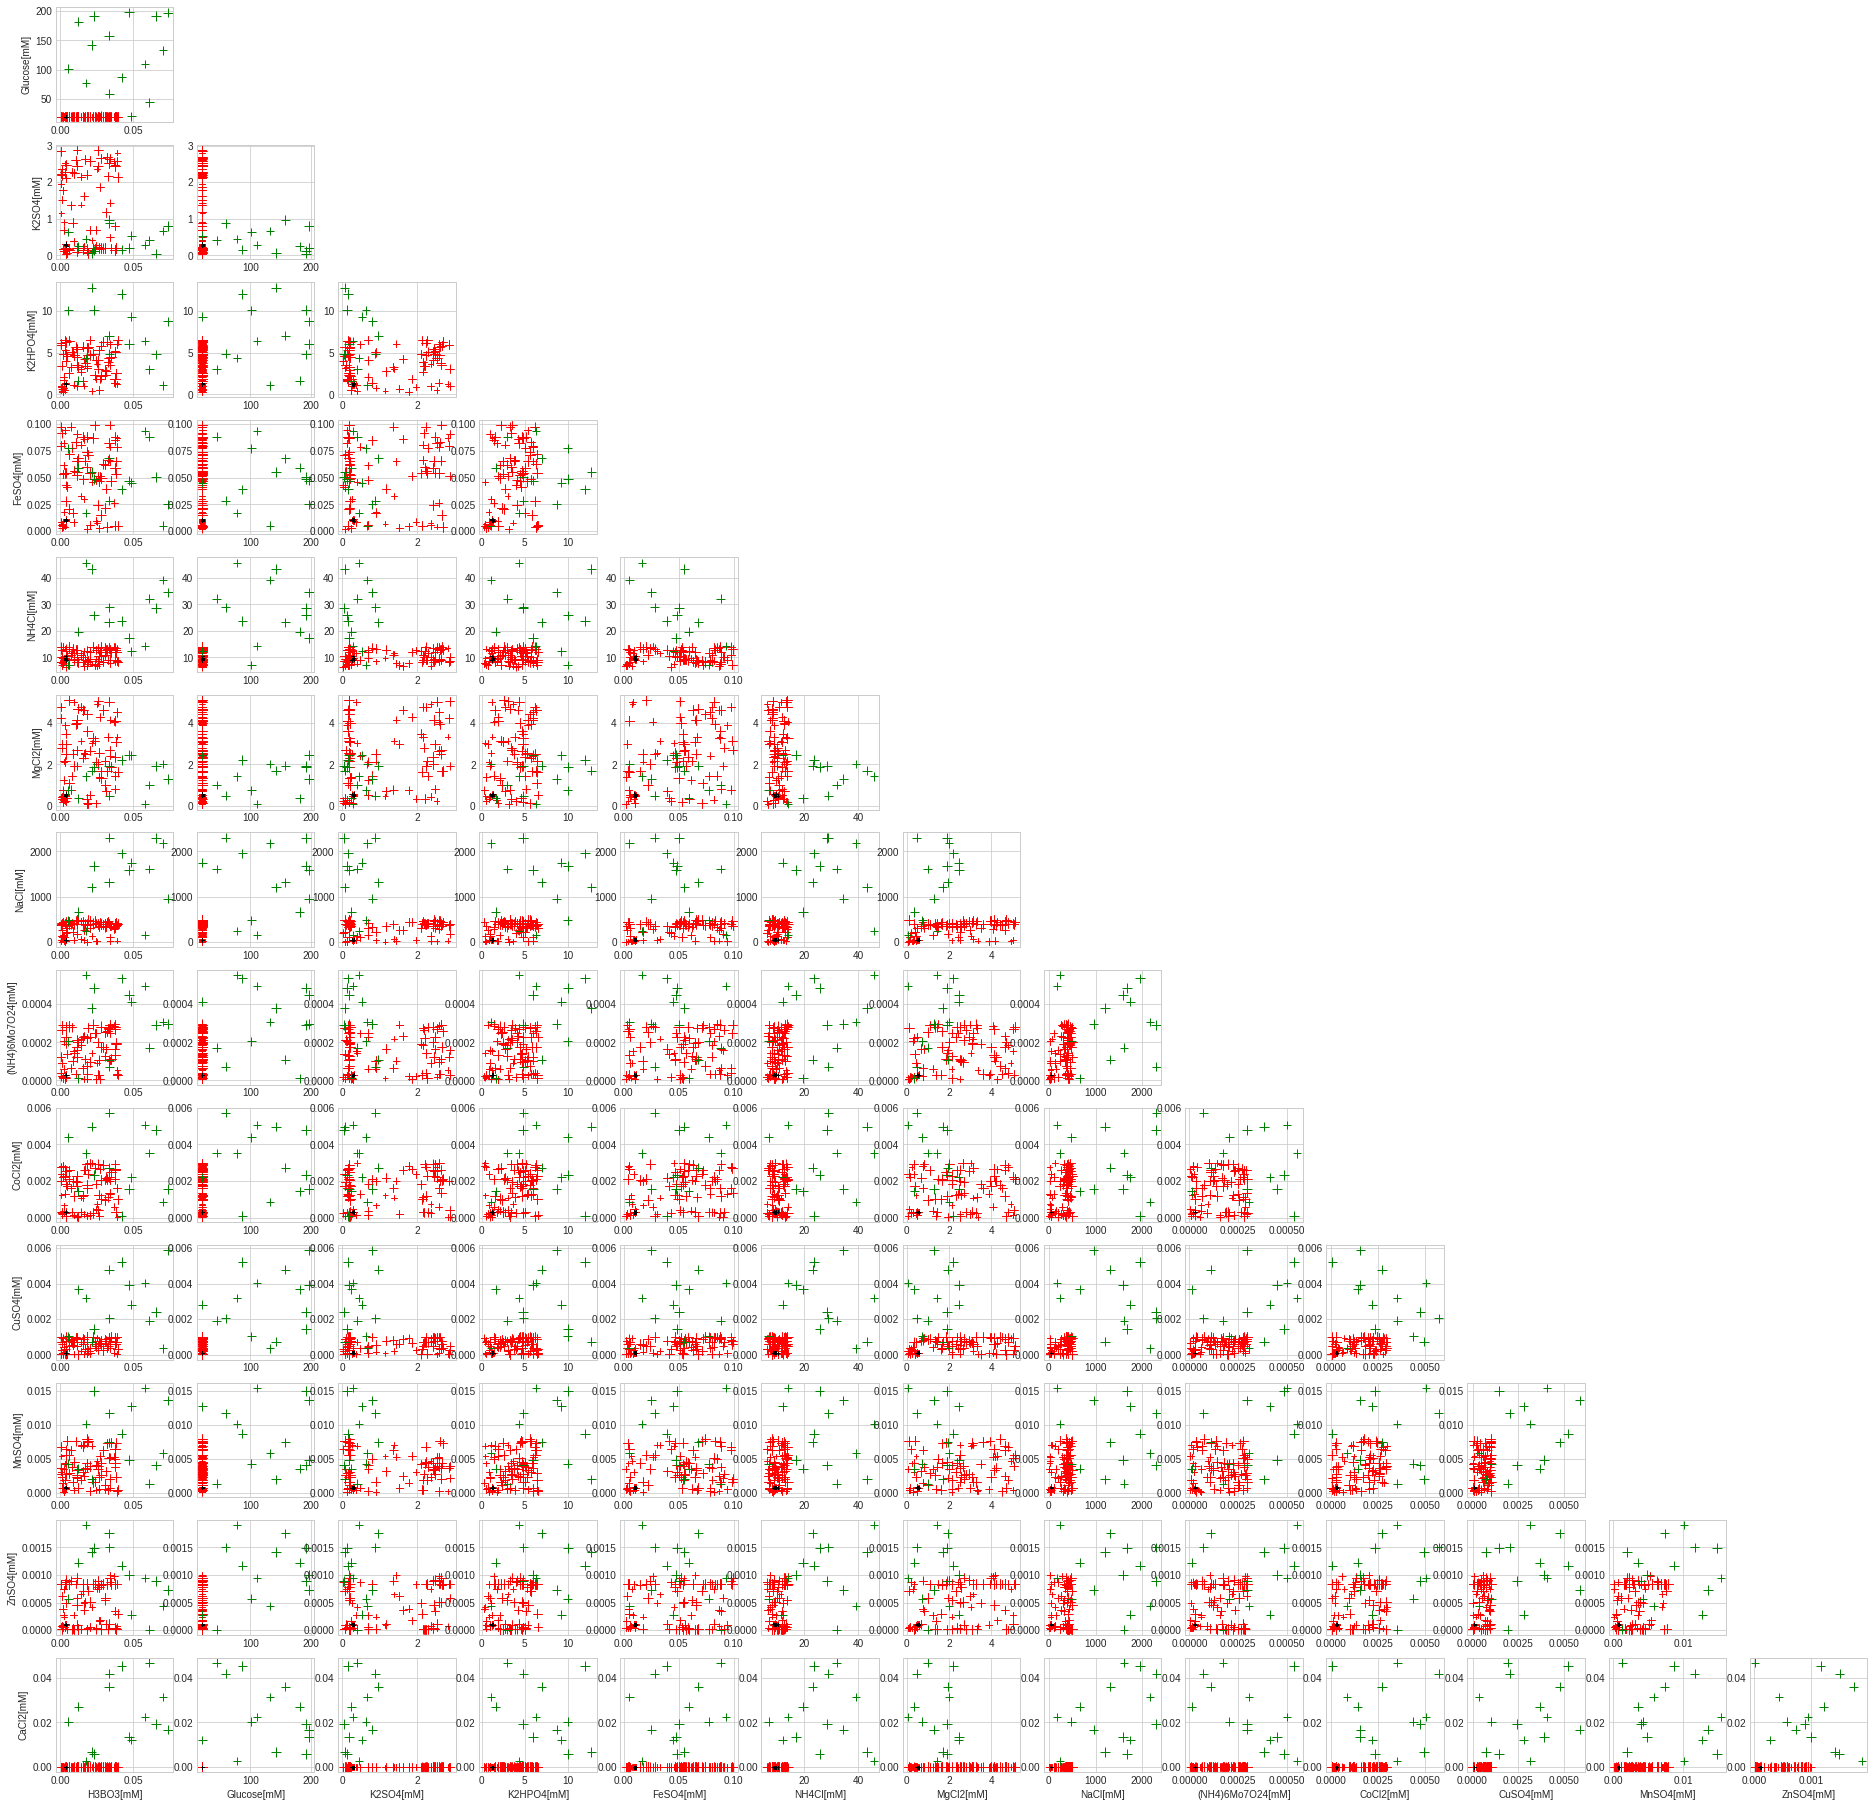

In [58]:
designs_pairwise(art, df_target, user_params, df_train)

In [55]:
df_target.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],Label,OD340_pred
0,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.93201,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,NaN
1,0.073964,197.001031,0.805718,8.730541,0.024996,34.4809,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.01677,LHS,NaN
2,0.005516,101.442383,0.635196,10.018421,0.077301,7.171802,0.739322,483.353887,0.000204,0.004384,0.001032,0.004261,0.000571,0.020192,LHS,NaN
3,0.061079,44.187891,0.408155,2.982336,0.08832,32.028222,0.998663,1609.826168,0.000172,0.003531,0.001917,0.001345,0.000011,0.046568,LHS,NaN
4,0.017981,77.852755,0.448481,4.31151,0.016822,45.664006,1.414916,242.476189,0.000552,0.003502,0.003175,0.010114,0.001898,0.002613,LHS,NaN


In [56]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_target.values[:, :-2]
        ) # posterior predictive statistics: mean and std

df_target['OD340_pred'] = predicted_mean
df_target['OD340_std'] = predicted_std
df_target.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],Label,OD340_pred,OD340_std
0,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.93201,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277
1,0.073964,197.001031,0.805718,8.730541,0.024996,34.4809,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.01677,LHS,0.590909,0.097057
2,0.005516,101.442383,0.635196,10.018421,0.077301,7.171802,0.739322,483.353887,0.000204,0.004384,0.001032,0.004261,0.000571,0.020192,LHS,0.520340,0.073375
3,0.061079,44.187891,0.408155,2.982336,0.08832,32.028222,0.998663,1609.826168,0.000172,0.003531,0.001917,0.001345,0.000011,0.046568,LHS,0.515505,0.074493
4,0.017981,77.852755,0.448481,4.31151,0.016822,45.664006,1.414916,242.476189,0.000552,0.003502,0.003175,0.010114,0.001898,0.002613,LHS,0.445810,0.068024
5,0.042196,86.844568,0.152045,11.989767,0.038928,23.714634,2.20286,1955.551815,0.000535,0.000074,0.005221,0.008697,0.001167,0.045129,LHS,0.604591,0.091930
6,0.033832,59.015584,0.881328,4.846981,0.028192,28.941574,0.474404,2299.8922,0.000071,0.005728,0.002046,0.011681,0.001505,0.041659,LHS,0.526423,0.086883
7,0.012424,181.876355,0.241431,1.656642,0.059312,19.734849,0.356876,663.059555,0.000011,0.001437,0.003679,0.003564,0.001221,0.027068,LHS,0.552825,0.087305
8,0.048945,20.311279,0.530003,9.252166,0.045107,12.28671,2.448971,1744.2988,0.000412,0.002198,0.002808,0.012728,0.000278,0.01213,LHS,0.521821,0.075250
9,0.02162,142.387906,0.062276,12.757317,0.0551,43.167051,1.695228,1203.273772,0.00038,0.004968,0.00073,0.001982,0.001415,0.006742,LHS,0.601153,0.087294


## Saving the generated designs

Include all replicates: 

In [57]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [58]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [59]:
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],Label,OD340_pred,OD340_std
Well,,,,,,,,,,,,,,,,,
A1,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.93201,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277
B1,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.93201,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277
C1,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.93201,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277
D1,0.073964,197.001031,0.805718,8.730541,0.024996,34.4809,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.01677,LHS,0.590909,0.097057
E1,0.073964,197.001031,0.805718,8.730541,0.024996,34.4809,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.01677,LHS,0.590909,0.097057


In [60]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target.to_csv(file) # This file will be used for the computation of volume transfers and data analysis